# Cimate Analysis and Exploration

In [1]:
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#ONLY DOING THIS because idk what this database looks like
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [3]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [4]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
measurement_query = """
                    SELECT
                        *
                    FROM
                        measurement
                    LIMIT 100
            """

In [6]:
conn = engine.connect()
df_measurement = pd.read_sql(measurement_query, con=conn)
conn.close()

In [7]:
df_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [8]:
station_query = """
            SELECT
                *
            FROM
                station
            LIMIT 100
        """

In [9]:
conn = engine.connect()
df_station = pd.read_sql(station_query, con=conn)
conn.close()

In [10]:
df_station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Precipitation Analysis

In [11]:
prcp_last_12_months = """
                        SELECT
                            date,
                            prcp
                        FROM
                            measurement
                        WHERE
                            date >= (
                                        SELECT
                                           date(MAX(date), '-365 day')
                                        FROM
                                            measurement
                                    )
                        ORDER BY
                            date
                        """

In [12]:
conn = engine.connect()
df_prcp = pd.read_sql(prcp_last_12_months, con=conn)
conn.close()

In [13]:
df_prcp["date"] = pd.to_datetime(df_prcp["date"])
df_prcp.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


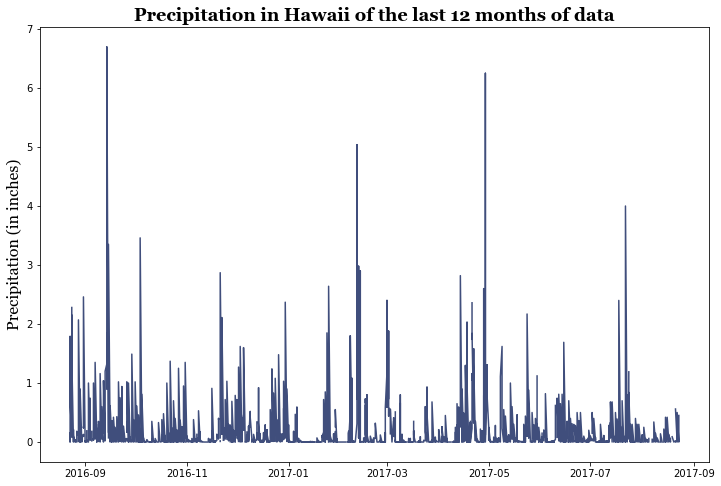

In [14]:
#figsize
plt.figure(figsize=(12,8))

#plot
plt.plot(df_prcp.date, df_prcp.prcp, color = "#404E7C")

#title and labels
plt.title("Precipitation in Hawaii of the last 12 months of data", fontweight="bold", fontsize=18, fontname="Georgia")
plt.ylabel("Precipitation (in inches)", fontsize=16, fontname="Georgia")
plt.xlabel("")

#create
plt.show()

### Summary Statistics

In [15]:
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

### Total Number Stations

In [16]:
num_stations_query = """
                    SELECT
                        count(*) as station_count
                    FROM
                        station
                """

In [17]:
conn = engine.connect()
df_num_stations = pd.read_sql(num_stations_query, con=conn)
conn.close()

df_num_stations

,station_count
0,9


### Most Active Stations

In [18]:
most_active_query = """
                    SELECT
                        s.station,
                        count(*) as tot_obs
                    FROM
                        station s
                    JOIN measurement m on s.station = m.station
                    GROUP BY s.station
                    ORDER BY
                        count(*) desc
                """

In [19]:
conn = engine.connect()
df_most_active = pd.read_sql(most_active_query, con=conn)
conn.close()

df_most_active

,station,tot_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


### Last 12 months of temperature observation data (TOBS)

In [20]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

In [21]:
#tobs
most_active_tobs = """
                SELECT
                    date,
                    station,
                    tobs
                FROM
                    measurement
                WHERE
                    date >= (
                                SELECT
                                    date(MAX(date), '-365 day')
                                FROM
                                    measurement
                            )
                    AND
                    station = (
                                SELECT
                                    s.station
                                FROM
                                    station s
                                JOIN measurement m on s.station = m.station
                                GROUP BY s.station
                                ORDER BY
                                    count(*) desc
                                LIMIT 1
                            )
                ORDER BY
                    date, station
              """

In [22]:
conn = engine.connect()
df_tobs = pd.read_sql(most_active_tobs, con=conn)
conn.close()

df_tobs

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0
...,...,...,...
347,2017-08-14,USC00519281,77.0
348,2017-08-15,USC00519281,77.0
349,2017-08-16,USC00519281,76.0
350,2017-08-17,USC00519281,76.0


In [23]:
most_active = df_tobs.groupby("station").size().sort_values(ascending=False).index[0]
most_active

'USC00519281'

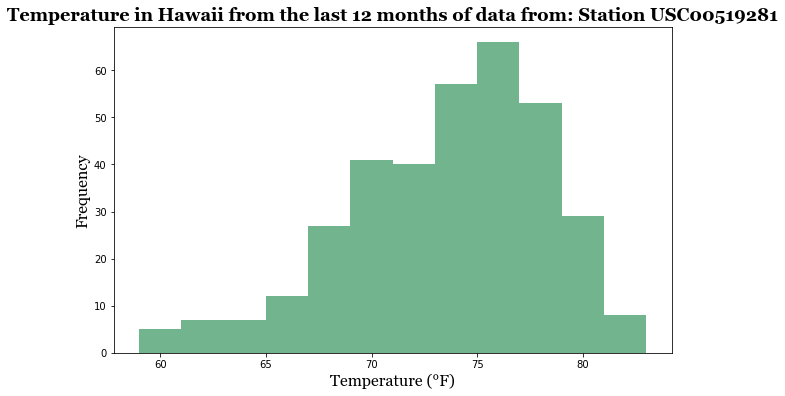

In [24]:
#figsize
plt.figure(figsize=(10,6))

#plot
plt.hist(df_tobs.tobs, bins=12, color= "#71B48D")

#title and labels
plt.title(f"Temperature in Hawaii from the last 12 months of data from: Station {most_active}", fontweight="bold", fontsize=18, fontname = "Georgia")
plt.ylabel("Frequency", fontsize=16, fontname= "Georgia")
plt.xlabel("Temperature (°F)", fontsize=16, fontname = "Georgia")

#create
plt.show() 